# Interpolation
___

**Remarks**
- Code will need to be modified a bit to reflect the use of a certain group of data instead of all data

In [1]:
import numpy as np
import pandas as pd
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from itertools import combinations

# from scipy.spatial.distance import pdist
# from scipy.stats import chisquare, chi2
from scipy.stats import ttest_1samp, t

from pykrige.ok import OrdinaryKriging
from pykrige.rk import Krige
import pykrige.kriging_tools as kt

from sklearn.model_selection import cross_val_predict

from joblib import Parallel, delayed
import multiprocessing

In [2]:
import prepostprocessing.pre_processing as preproc
import prepostprocessing.post_processing as postproc
import nugget_estimation.kriging_tools as krigingtools
import nugget_estimation.detrending as detrending
import plots.plots as plots
import prepostprocessing.cleaning as cleaning
import cross_validation.leave_one_out_cross_validation as loocv

import qapf.qapf as qapf
import statistics.ttest as ttest
import statistics.simulations as sim

import toolbox.toolbox as tb

In [3]:
# Load jupyter extension to reload packages before executing user code.
# https://ipython.readtheMLcs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all packages (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [4]:
# You only need to run this cell once if you want to have multiple outputs in all your notebooks.
# It is a general setting so you can set this cell's status to 'raw'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
coordinates_latlon = preproc.load_obj("coordinates_area2")
coordinates_utm = preproc.load_obj("coordinates_utm_area2")
mineralogy = preproc.load_obj("mineralogy_area2")
mineralogy_clr = preproc.load_obj("mineralogy_clr_area2")
mineralogy_pca = preproc.load_obj("mineralogy_pca_area2")
mineralogy_pca_df = preproc.load_obj("mineralogy_pca_area2_df")
metadata = preproc.load_obj("metadata_area2")

## EDA
___

In [6]:
# Get number of control points that will be used
number_of_control_points = coordinates_utm.shape[0]
number_of_control_points

1039

In [7]:
coordinates_utm

,Y_UTM,X_UTM,ZoneNumber,ZoneLetter
1,788062.538051,4.936585e+06,53,T
7,609204.390926,5.261750e+06,53,T
8,683161.686140,5.345172e+06,53,T
13,566277.769165,5.115580e+06,53,T
16,513561.171031,5.820370e+06,53,T
...,...,...,...,...
4646,626698.329397,4.987292e+06,53,T
4649,461509.372701,5.662951e+06,53,T
4650,898558.158803,5.868297e+06,53,T
4654,620259.749413,5.148324e+06,53,T


In [8]:
coordinates_utm = coordinates_utm.rename({"X_UTM": "Y", "Y_UTM": "X"}, axis=1)

In [9]:
# FILL IN SHORT NAME HERE THAT WILL BE USED WHEN SAVING THE PLOT (e.g. "G1")
group_name = "area2"

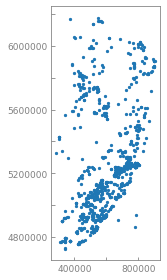

In [10]:
# Plot control points with labels
plots.plot_map_with_control_points(coordinates_utm, group_name, label_size=4, subset=["X", "Y"],
                                   show_labels=False,
                                  skip_xaxis_label=2, skip_yaxis_label=2, 
                                  skip_xaxis_start=1, skip_yaxis_start=1)

In [11]:
# Show unique zone letters and zone numbers of utm coordinates
coordinates_utm["ZoneNumber"].unique()
coordinates_utm["ZoneLetter"].unique()

array([53], dtype=int64)

array(['T'], dtype=object)

In [12]:
# Calculate minimum and maxmin lag distance between two points of the dataset
distance_matrix = krigingtools.calculate_and_sort_square_distance_matrix(coordinates_utm[["X", "Y"]])

min_lag_distance = np.amin(distance_matrix)
max_lag_distance = np.amax(distance_matrix)
min_lag_distance, max_lag_distance

(0.036756900077009005, 1462675.8606845895)

(array([3.2336e+04, 3.9686e+04, 6.1804e+04, 6.9812e+04, 6.0396e+04,
        6.5690e+04, 6.1356e+04, 5.2112e+04, 5.3582e+04, 4.6932e+04,
        5.3996e+04, 4.7120e+04, 4.1102e+04, 3.9522e+04, 3.3524e+04,
        2.8934e+04, 2.8726e+04, 2.8920e+04, 2.5790e+04, 2.2308e+04,
        2.2722e+04, 2.1746e+04, 2.0004e+04, 1.6014e+04, 1.7298e+04,
        1.4010e+04, 1.3996e+04, 1.0274e+04, 1.0212e+04, 8.7160e+03,
        7.9820e+03, 6.3000e+03, 4.4160e+03, 4.8840e+03, 1.8900e+03,
        2.4840e+03, 1.0080e+03, 4.3800e+02, 4.1200e+02, 2.8000e+01]),
 array([3.67569001e-02, 3.65669324e+04, 7.31338280e+04, 1.09700724e+05,
        1.46267619e+05, 1.82834515e+05, 2.19401410e+05, 2.55968306e+05,
        2.92535202e+05, 3.29102097e+05, 3.65668993e+05, 4.02235888e+05,
        4.38802784e+05, 4.75369680e+05, 5.11936575e+05, 5.48503471e+05,
        5.85070366e+05, 6.21637262e+05, 6.58204158e+05, 6.94771053e+05,
        7.31337949e+05, 7.67904844e+05, 8.04471740e+05, 8.41038636e+05,
        8.77605531e+05

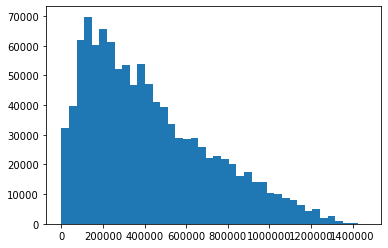

In [13]:
plt.hist(distance_matrix.flatten(), bins=40)

In [14]:
np.where(distance_matrix == 0)

(array([], dtype=int64), array([], dtype=int64))

## Critical distance estimation
___

In [15]:
# Range (lag distance at which the sill is reached; in meters)

# Depending on how many principal components you will use, 
# you will have to add more entries to this list.

# Modified the range since variograms are not correct yet
# range_ = [100000] * 15
range_ = [120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 100000, 100000, 100000, 100000, 100000, 100000]



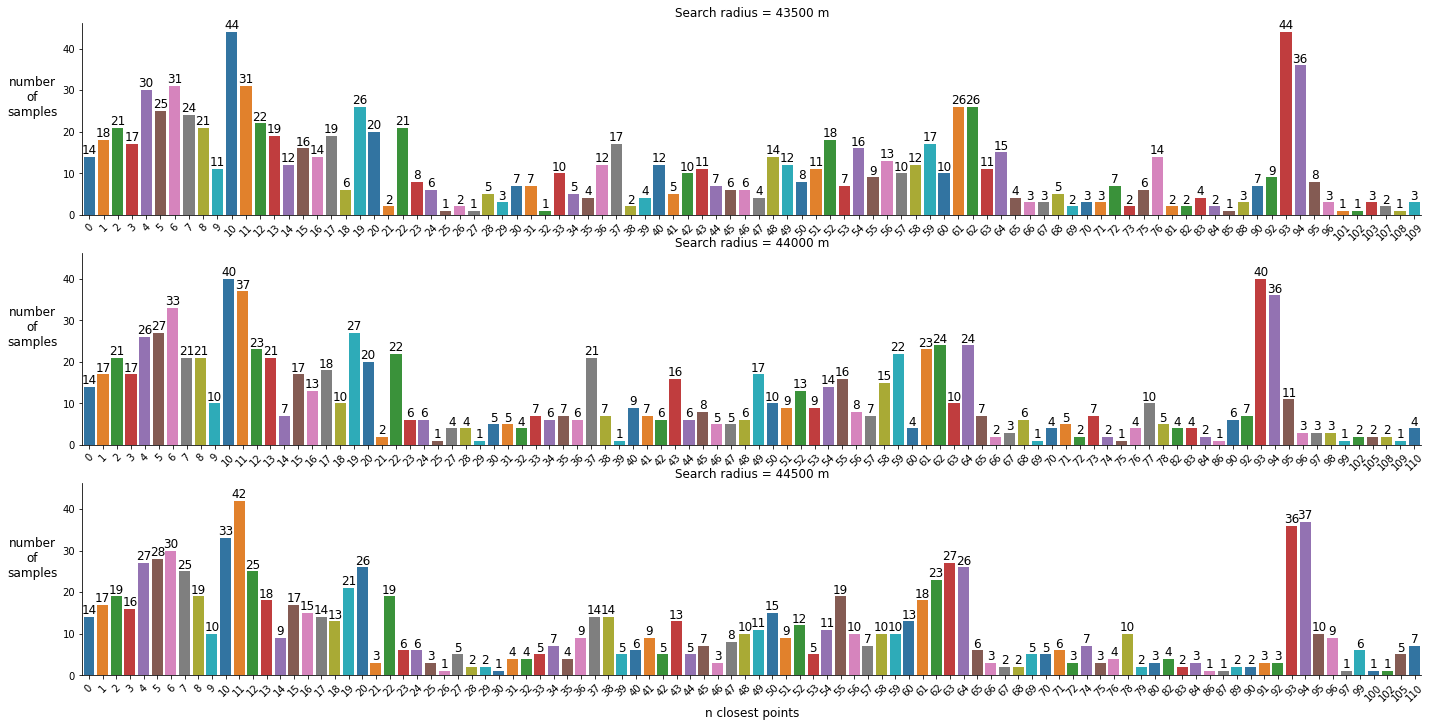

In [16]:
# You can adjust the radius parameters below to change the slider settings
# to visualize the figures interactively
plots.interactive_plot_search_radius(coordinates_utm, orient='rows', 
                                     radius_default=44000, # Default slider position
                                     radius_min=30000,  # Slider start
                                     radius_max=60000, # Slider stop
                                     radius_step=500,  # Slider step
                                     radius_offset=500) # Offset between visualizations shown

# The x-axis stands for 'n_neighbours'

In [17]:
# Critical distance (in meters)
# This is the distance where at least 95% of your samples
# will have at least 3 neighbours within that distance

# You can refine this value later on, or we can use the range 
# instead of the critical distance as the only value for the search radius
critical_distance = 44000

In [18]:
# This is basically creating a list of how many neighbours each data point has 
# within the critical_distance and within the range
nvalues_control_points = {}

for radius in (0.05, critical_distance, range_[0]):
    temp = krigingtools.find_points_within_search_radius(
               krigingtools.calculate_and_sort_square_distance_matrix(coordinates_utm),
               search_radius=radius # 'search_radius' should be equal to 'radius' here, not 'critical_distance'
           )
    nvalues_control_points[radius] = pd.Series(temp, index=coordinates_utm.index)
    
# You're performing a calculation in a for loop so we want to check how many neighbours each data point has 
# within the specified radius in the tuple (0.05, critical_distance, range_[0]). 
# So for each of these specified distances, the function will be executed and 
# the result stored in the nvalues_control_points dictionary

In [19]:
# Number of samples that may still have less than 3 neighbours within the critical distance
number_of_control_points * 0.05

51.95

In [20]:
# Check number of samples outside of critical distance
samples_outside_critical_distance = nvalues_control_points[critical_distance][nvalues_control_points[critical_distance] < 3].index.tolist()
len(samples_outside_critical_distance)

# 0.05 sample above 51.95

52

In [21]:
# Overview of samples that are outside search_radius
mineralogy_pca_df.loc[samples_outside_critical_distance, :]

,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09,PC10,PC11,PC12,PC13
1,1.487880,-0.285481,0.288952,-0.077558,-0.278738,-1.304030,0.950395,-0.141482,-0.871135,-0.042956,0.329448,0.238036,4.988034e-16
16,0.154234,0.653656,0.468895,0.993410,0.258180,0.029939,-0.151941,0.091591,-0.035518,0.333694,-0.046614,0.262552,2.102989e-16
83,1.090994,-0.353066,0.630796,-0.642222,0.162808,-1.804057,1.861200,-1.205815,0.832515,0.433174,0.027721,0.004638,1.519674e-15
113,2.810491,0.056655,-0.435380,0.639919,-0.019753,0.064280,-1.563957,-0.940547,-0.152688,-0.101187,0.187602,-0.032884,-7.995384e-16
207,1.613143,-0.405652,0.148397,-0.088862,1.312119,-0.449539,-0.101271,0.542993,-0.015301,-0.023137,0.080867,0.031874,3.908164e-16
363,3.115132,0.313153,2.238603,-2.010482,-1.264655,-0.031202,0.498742,0.418100,-0.007721,-0.522039,0.082670,0.003803,-7.671694e-17
461,1.021666,-0.138104,0.028288,0.094271,0.270863,-0.374542,0.656251,0.036707,0.284427,-0.076056,-0.031786,0.050384,3.169317e-16
553,0.873003,0.671696,1.451089,-1.443502,1.811720,-0.681656,-0.558547,0.031396,0.255669,0.413645,0.240268,0.023054,-2.063067e-16
566,0.805805,1.254842,0.449316,1.123463,-0.097543,-0.668274,-0.175621,0.376743,0.278155,0.186719,-0.043701,0.037210,3.833562e-16
771,2.275927,-0.493790,-0.982327,-0.427667,0.084487,0.681361,2.213730,-1.285320,-1.150138,0.230079,-0.202850,0.055875,8.619952e-16


____

## Create high resolution grids
____

In [22]:
# Determine (wide) grid boundaries
X = coordinates_utm.iloc[:, 0].values
Xmin = np.min(X) - critical_distance * 1.05
Xmax = np.max(X) + critical_distance * 1.05

Y = coordinates_utm.iloc[:, 1].values
Ymin = np.min(Y) - critical_distance * 1.05, 
Ymax = np.max(Y) + critical_distance * 1.05

coordinates_boundaries = np.array([[Xmin, Xmax], [Ymin, Ymax]])
coordinates_boundaries

array([[237832.25743787782, 952978.2634567402],
       [(4680698.080159552,), 6220991.776912029]], dtype=object)

In [23]:
# Set approximate number of points along each axis
n_points = 350

temp = {}
x, y = coordinates_boundaries

temp["x_start (m)"] = int(np.floor(x[0]))
temp["x_end (m)"] = int(np.floor(x[1]))
temp["y_start (m)"] = int(np.floor(y[0]))
temp["y_end (m)"] = int(np.floor(y[1]))

print("x", x)
print("y", y)

temp["x_range (m)"] = int(np.floor(x[1])) - int(np.floor(x[0]))
temp["y_range (m)"] = int(np.floor(y[1])) - int(np.floor(y[0]))
print("x range: ", temp["x_range (m)"])
print("y range: ", temp["y_range (m)"])

ranges = {"x": temp["x_range (m)"],
          "y": temp["y_range (m)"],
         }

threshold = 10000000
for dimension, ranger in ranges.items():
    if ranger < threshold:
        smallest_dimension = dimension
        threshold = ranger
print("smallest dimension", smallest_dimension)

x_spacing, dx = np.linspace(x[0], x[1], n_points, retstep=True)
y_spacing, dy = np.linspace(y[0], y[1], n_points, retstep=True)

steps = {"x": dx,
         "y": dy,
        }

print("theoretical x spacing: ", dx)

xgrid = np.arange(x[0]-dx, x[1]+dx, steps[smallest_dimension])
ygrid = np.arange(y[0]-dy, y[1]+dy, steps[smallest_dimension])

print("actual x spacing: ", xgrid[1] - xgrid[0])
print("actual y spacing: ", ygrid[1] - ygrid[0])

temp["x_spacing (m)"] = np.round(xgrid[1] - xgrid[0], 2)
temp["y_spacing (m)"] = np.round(ygrid[1] - ygrid[0], 2)

print("Number of points: ", len(xgrid) * len(ygrid))
print("xy grid: ", len(xgrid), len(ygrid), "\n")

temp["#xgrid_points"] = len(xgrid)
temp["#ygrid_points"] = len(ygrid)
temp["#total_grid_nodes"] = len(xgrid) * len(ygrid)

coordinates_grids = [xgrid, ygrid]
coordinates_grids_details = temp

# Assigned to a different variable (name) because later on 'grid' gets used in the code
grid = coordinates_grids

x [237832.25743787782 952978.2634567402]
y [(4680698.080159552,) 6220991.776912029]
x range:  715146
y range:  1540293
smallest dimension x
theoretical x spacing:  2049.128957074104
actual x spacing:  2049.1289570741064
actual y spacing:  2049.1289570741355
Number of points:  266112
xy grid:  352 756 



## Classification map
___

We will have to decide on a certain classification scheme before we could use this.  
Another option might be to use a condensed version of the 'type_granite' column.

**Yep**

## Detrending
____

In [24]:
# Check if there is a trend present in the data
# This is the case if R² is above say 0.70 

for component in mineralogy_pca_df.columns.tolist()[:-1]:
    for order in [1, 2]:
        print("R² for", component, "order =", order, ":")
        detrending.detrend(coordinates_utm, 
                           mineralogy_pca_df[component], 
                           order=order, 
                           verbose=False, 
                           plot_points=False)[1]

R² for PC01 order = 1 :


0.026849394622496026

R² for PC01 order = 2 :


0.0383518053040407

R² for PC02 order = 1 :


0.02962970569882717

R² for PC02 order = 2 :


0.029957783186074227

R² for PC03 order = 1 :


0.15330396332785923

R² for PC03 order = 2 :


0.1537383068507201

R² for PC04 order = 1 :


0.020281255590879232

R² for PC04 order = 2 :


0.07496823942493391

R² for PC05 order = 1 :


4.172081082376433e-05

R² for PC05 order = 2 :


0.0007205946010815367

R² for PC06 order = 1 :


0.0006827685627240898

R² for PC06 order = 2 :


0.0010559565447327834

R² for PC07 order = 1 :


0.003088139081160568

R² for PC07 order = 2 :


0.004168632961387919

R² for PC08 order = 1 :


0.0006245075165677294

R² for PC08 order = 2 :


0.0017029578909802945

R² for PC09 order = 1 :


0.005239253016094181

R² for PC09 order = 2 :


0.010976742171012521

R² for PC10 order = 1 :


0.006372495723783511

R² for PC10 order = 2 :


0.021204897051579685

R² for PC11 order = 1 :


0.03439238202959338

R² for PC11 order = 2 :


0.05175586450031466

R² for PC12 order = 1 :


0.004213237735337216

R² for PC12 order = 2 :


0.020899674127198065

## Variogram modelling
___

* Variogram model (str)
* Sill (float)
* Range (float)
* Nugget (float)
* Number of lag bins (int)
* Weighted (Bool)

In [25]:
# Nugget (variance at lag=0 metric)

# Since we are not dealing with point count data here,
# we can not use the formulas from our paper we have talked about
# Therefore I would just start with nugget=0 and perhaps later change this

# Depending on how many principal components you will use, 
# you will have to add more entries to this list.
nugget_ = [1.0685, 0.6350, 0.5930, 0.4405, 0.3148, 0.2059, 0.2105, 0.1955, 0.1073, 0., 0., 0., 0., 0., 0.]

In [26]:
PC_nr_list = [nr[2:] for nr in mineralogy_pca_df.columns]
PC_nr_list

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13']

In [27]:
# Sill (total variance metric)

# A 'list comprehension' construction is used here
sill_ = [mineralogy_pca_df.loc[:, f"PC{i}"].values.var(ddof=1) 
         for i in PC_nr_list]

In [28]:
# Variogram model parameters dictionary

variogram_model_parameters = {}

for i, PC in enumerate(mineralogy_pca_df.columns):
    parameters = {}
    parameters["sill"] = sill_[i]
    parameters["range"] = range_[i]
    parameters["nugget"] = nugget_[i]
        
    variogram_model_parameters[PC] = parameters

In [29]:
# Variogram model

# You can choose between ["exponential", "linear", "spherical", "power", "gaussian"]
# see https://pykrige.readthedocs.io/en/latest/variogram_models.html for equations
variogram_model = "exponential"

In [30]:
# Number of lag bins

n_lags = int(np.floor(np.sqrt(coordinates_utm.shape[0])))
n_lags

32

In [31]:
# Set utm coordinates to use in variogram

X = coordinates_utm.iloc[:, 0].values
Y = coordinates_utm.iloc[:, 1].values

PC01
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.712367153651484
Full Sill: 1.780867153651484
Range: 120000
Nugget: 1.0685 



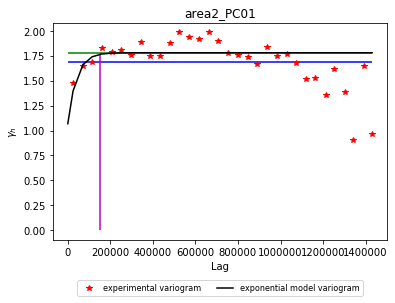

Calculating statistics on variogram model fit...
PC02
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.6348878572701646
Full Sill: 1.2698878572701646
Range: 120000
Nugget: 0.635 



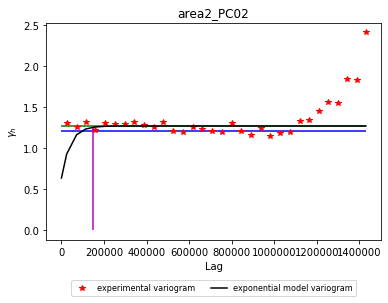

Calculating statistics on variogram model fit...
PC03
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.2541277028343827
Full Sill: 0.8471277028343827
Range: 120000
Nugget: 0.593 



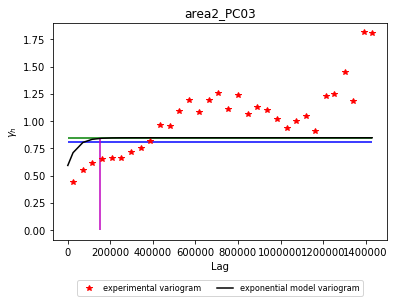

Calculating statistics on variogram model fit...
PC04
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.18877941346236482
Full Sill: 0.6292794134623648
Range: 120000
Nugget: 0.4405 



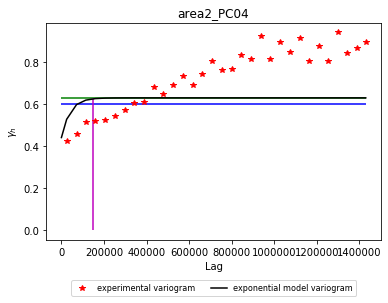

Calculating statistics on variogram model fit...
PC05
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.1348601523454241
Full Sill: 0.4496601523454241
Range: 120000
Nugget: 0.3148 



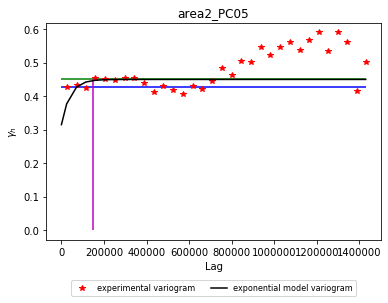

Calculating statistics on variogram model fit...
PC06
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.0882143091411409
Full Sill: 0.2941143091411409
Range: 120000
Nugget: 0.2059 



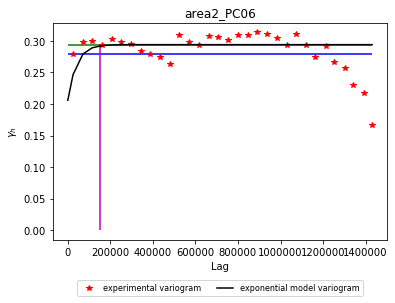

Calculating statistics on variogram model fit...
PC07
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.052600729338776325
Full Sill: 0.2631007293387763
Range: 120000
Nugget: 0.2105 



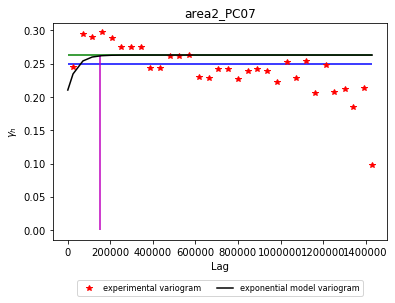

Calculating statistics on variogram model fit...
PC08
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.04892131675262967
Full Sill: 0.24442131675262968
Range: 120000
Nugget: 0.1955 



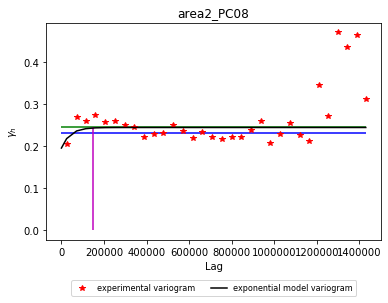

Calculating statistics on variogram model fit...
PC09
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.045975942838416134
Full Sill: 0.15327594283841614
Range: 120000
Nugget: 0.1073 



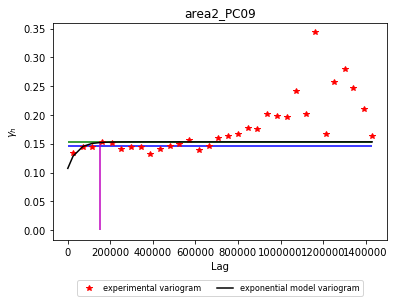

Calculating statistics on variogram model fit...
PC10
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.06849189293623412
Full Sill: 0.06849189293623412
Range: 100000
Nugget: 0.0 



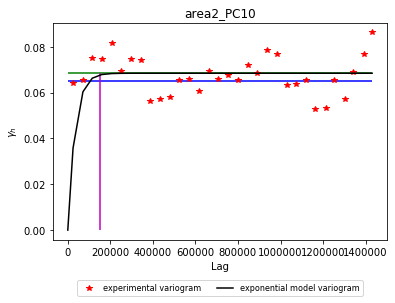

Calculating statistics on variogram model fit...
PC11
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.01789169251472656
Full Sill: 0.01789169251472656
Range: 100000
Nugget: 0.0 



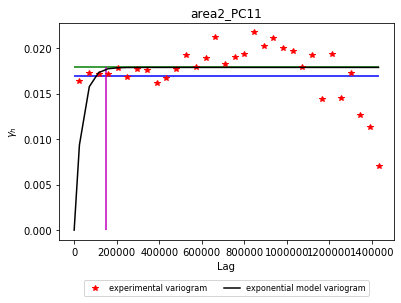

Calculating statistics on variogram model fit...
PC12
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.005248604132679928
Full Sill: 0.005248604132679928
Range: 100000
Nugget: 0.0 



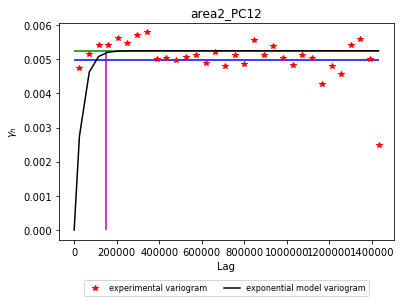

Calculating statistics on variogram model fit...
Wall time: 7.19 s


In [32]:
%%time
# Initialize empty dictionary
variograms = {}

# Loop though the diiferent principal components
for component in mineralogy_pca_df.columns.tolist()[:-1]:
    print(component)
    # Subset principal component to use
    data = mineralogy_pca_df.loc[:, component].values
    variograms[component] = \
        OrdinaryKriging(X, Y, data,
                        variogram_model='exponential',
                        variogram_parameters=variogram_model_parameters[component],
                        nlags=n_lags,
                        verbose=True,
                        enable_statistics=False,
                        enable_plotting=True,
                        weight=True,
                        saveplot=True,
                        coordinates_type='euclidean',
                        saveloc="../_FIGURES/variograms/",
                        principal_component=component,
                        pluton=group_name,
                        show_nlag_pairs=False, # Turn off displaying number of lag pairs in lag bin
                        show_range_determine_guide=True, # 0.95 * sill highlighted with blue line to help determining range
                        range_estimate=150000) # Pass in value in meters to display a line at range estimate; set value to None to not display line
    
# NOTE that ideally Q1 is close to zero, Q2 is close to 1, and cR is as small as possible.

## Leave One Out Cross Validation (LOOCV) of PCA
____

In [33]:
# If you have run the cross validation before you can load the results by
# running this cell and don't have to run the next cell anymore.
CV_results = preproc.load_obj("CV_results_fast")

In [34]:
# Use this cross validation to check the hyper-parameters of your chosen variogram model 
# such as the search_radius, variogram_model, lag_bins etc.

# Cross validation parameter dictionary to use
# You can remove or add options here which will decrease or increase the number 
# of combinations of parameters the cross validation will run
cv_param_dict = {}

for component in mineralogy_pca_df.columns.tolist()[:-1]:
    cv_param_dict[component] = {"method": ["ordinary"],
                                "variogram_model": ["exponential", "spherical"],
                                "variogram_model_parameters": [variogram_model_parameters[component]],
                                "nlags": [n_lags],
                                "weight": [True],
                                "n_closest_points": [number_of_control_points],
                                "search_radius": [range_[0]]
                                }

# The CV function below uses parallel processing to speed things up
# Your CPU will thus reach 100% probably
# To reduce the number of parallel processes to use you can change the following value
# Defaults to -1 to use all available CPU cores; change to number between 1 and 8 e.g. 
# depending on how many cores your CPU has
n_jobs = -1 

In [35]:
%%time
# Run CV and get estimators (using default MSE scorer)

# Instead of running the CV for all the PCs, let's start with only the first 3 
# to get an idea of what are the best parameters to use for the first 3 PCs.
# In a later step we can then obtain the best parameters for all PCs that have 
# a sensible variogram; here this would mean up to and including PC09.
# To specify which PCs to use, you can pass them in as list to the 'components_to_use' variable

# Another change I've made, is that instead of performing leave-one-out-CV 
# where the train set is equal to n_sample - 1 and the test set is equal to 1,
# it makes sense to here use a different strategy, since you're dealing with many more samples.
# Therefore I've included the 'cv_folds' parameter where you can specify 
# the number of train/test groups you want to use during CV
# Let's start with ten groups, which basically means that 
# you use 90% of the samples as train set and 10% as test test
# and this in 10 combinations.

# A a later stage we could change the CV to use a statified cv_fold
# meaning that it ensures for example that for every train/test grouping of the 10 groups
# equal numbers of samples of spcified grouping variable are used 
# (for example your time category or classification later on)

# I've also included the '%%time' statement at the beginning of the cell,
# so that at the end of the calculation you can see how much time it took.

# Have a look here if you want some background info on the CV method used:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

estimators = loocv.perform_loocv(mineralogy_pca_df,
                                 coordinates_utm,
                                 cv_param_dict,
                                 n_jobs=n_jobs,
                                 cv_folds=10,
                                 components_to_use=[f"PC0{i}" for i in range(1, 10)])

PC01
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    8.0s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    8.2s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    9.7s finished
C:\Users\Sebastian\Anaconda3\envs\main\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC02
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    5.1s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    5.3s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC03
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    5.2s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    5.4s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC04
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    5.2s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    5.4s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC05
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    5.2s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    5.3s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC06
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    5.3s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    5.4s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC07
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    5.2s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    5.4s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC08
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    5.3s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    5.4s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC09
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    5.2s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    5.4s remaining:    1.7s


Wall time: 1min 7s


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    7.0s finished


In [36]:
# Convert estimators to dict of dataframes
CV_results = loocv.convert_scores_to_df(estimators)

In [37]:
# Save CV_results to pickle file for easy use later
# These are the results from the 56min CV above (with only first 3 PCs)
preproc.save_obj(CV_results, "CV_results_summarized")

In [38]:
# Save CV_results to pickle file for easy use later
# These are the results from the 2min CV above (with only first 9 PCs, simple parameters)
preproc.save_obj(CV_results, "CV_results_fast")

In [39]:
# Quick look at best results per PC
loocv.print_best_scores(CV_results)

PC01
rank_test_score                    2
mean_test_score              1.79287
std_test_score               1.34682
mean_train_score         8.20006e-31
param_method                ordinary
param_variogram_model    exponential
param_search_radius           120000
Name: 0, dtype: object


PC02
rank_test_score                    2
mean_test_score              1.05058
std_test_score              0.201079
mean_train_score         7.63934e-31
param_method                ordinary
param_variogram_model    exponential
param_search_radius           120000
Name: 0, dtype: object


PC03
rank_test_score                    2
mean_test_score             0.662727
std_test_score              0.121056
mean_train_score                   0
param_method                ordinary
param_variogram_model    exponential
param_search_radius           120000
Name: 0, dtype: object


PC04
rank_test_score                    2
mean_test_score             0.539472
std_test_score              0.111541
mean_train_score 

## Calculating predictions for best model
____

In [40]:
# Here you can specify the components and search_radii you want to use 
# when performing the kriging and performing the postprocessing calculations
components_to_use = [f"PC{i:02d}" for i in range(1, 5)]
search_radii = [range_[0]]

In [41]:
estimators_final = {}

for component in components_to_use:  # Changed to only first 9 PCs
    for radius in search_radii:  # Removed critical_distance
        for variable_to_fit in ["estimates"]:

            estimators_final[f"{component}_{radius}_{variable_to_fit}"] = \
                Krige(method='ordinary',
                      variogram_model=variogram_model,
                      variogram_model_parameters=variogram_model_parameters[component],
                      nlags=n_lags,
                      weight=True,
                      n_closest_points=number_of_control_points,
                      search_radius=radius,
                      variable_to_fit=variable_to_fit)

In [42]:
# Run this cell if you have previously run the next cell and saved its outcome
kriging_predictions = preproc.load_obj("kriging_predictions")

In [43]:
%%time
# You can again change the n_jobs to lower the #CPU cores used for parallel processing
# Also set the cv_folds variable below
cv_folds = 10

kriging_predictions = {}

for component in components_to_use:  # Changed to only first 9 PCs
    for radius in search_radii:  # Removed critical_distance
        for variable_to_fit in ["estimates"]:
            
            # Let's print out the combination to see where we are in the loops
            print(component, radius, variable_to_fit)
            
            kriging_predictions[f"{component}_{radius}_{variable_to_fit}"] = \
                cross_val_predict(estimators_final[f"{component}_{radius}_{variable_to_fit}"], 
                                  X=np.stack((coordinates_utm["X"],
                                              coordinates_utm["Y"]), axis=1),
                                  y=mineralogy_pca_df[component],
                                  cv=cv_folds,
                                  n_jobs=4,
                                  verbose=5)

PC01 120000 estimates


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:    2.6s remaining:    1.7s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


PC02 120000 estimates


[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


PC03 120000 estimates


[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


PC04 120000 estimates


[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:    0.8s remaining:    0.5s


Wall time: 7.38 s


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.2s finished


In [44]:
preproc.save_obj(kriging_predictions, "kriging_predictions")

## Calculate clr solutions
____

In [45]:
kriging_estimates_df = {}

for radius in search_radii:
    temp = {}
    
    for component in components_to_use:
        key = f"{component}_{radius}_estimates"
        temp[key] = kriging_predictions[key]

    kriging_estimates_df[f"{radius}"] = pd.DataFrame.from_dict(temp)
    kriging_estimates_df[f"{radius}"].index = mineralogy_pca_df.index
    kriging_estimates_df[f"{radius}"].columns = components_to_use
    
    print(f"{radius}")
    kriging_estimates_df[f"{radius}"].head()

120000


,PC01,PC02,PC03,PC04
1,-0.336342,1.233933,0.618873,0.074721
7,-0.549491,0.128073,0.292042,0.254326
8,-0.418788,-0.000228,0.255997,0.233333
13,0.125176,-0.971352,0.285531,0.460417
16,-0.845672,-0.168093,0.795804,0.401941


In [46]:
kriging_estimates_clr = {}

for ncomp in range(1, len(components_to_use) + 1):
    for radius in search_radii:

        kriging_estimates_clr[f"{ncomp}_{radius}"] = \
            postproc.reverse_pca(mineralogy_pca, 
                                 kriging_estimates_df[f"{radius}"],
                                 mineralogy_clr,
                                 n_comp=ncomp)

In [47]:
solutions_clr = {}

for ncomp in range(1, len(components_to_use) + 1):
    for radius in search_radii:

        solutions_clr[f"{ncomp}_{radius}"] = \
            pd.DataFrame(kriging_estimates_clr[f"{ncomp}_{radius}"], 
                         index=mineralogy_clr.index, 
                         columns=mineralogy_clr.columns)

In [48]:
residuals_clr = {}

for ncomp in range(1, len(components_to_use) + 1):
    for radius in search_radii:

        residuals_clr[f"{ncomp}_{radius}"] = \
            mineralogy_clr.subtract(solutions_clr[f"{ncomp}_{radius}"])

In [49]:
for ncomp in range(1, len(components_to_use) + 1):
    for radius in search_radii:
        temp = pd.merge(residuals_clr[f"{ncomp}_{radius}"], 
                        pd.DataFrame(nvalues_control_points[radius], 
                                     columns=["n_closest_points"]), 
                        left_index=True, 
                        right_index=True)\
                 .sort_values("n_closest_points")
        
        temp.to_excel(f"../_RESULTS/Residuals/residuals_clr_{ncomp}_{radius}_{group_name}.xlsx")

In [50]:
preproc.save_obj(residuals_clr, "residuals_clr")

In [51]:
preproc.save_obj(nvalues_control_points, "nvalues_control_points")

## Model selection
____

In [52]:
# Get MSPE_Q values and select best model based on it
# Make sure the selected model passes the Hotelling's T² 2-sample test above, though
MSPE_Q = {}
best_MSPE_Q = 1000

for ncomp in range(1, len(components_to_use) + 1):
    for radius in search_radii:

        # Calculate MSPE_Q from clr residuals
        MSPE_Q_temp = np.mean(np.sum(residuals_clr[f"{ncomp}_{radius}"] ** 2, axis=1), axis=0)

        if MSPE_Q_temp < best_MSPE_Q:
            # Store best MSPE_Q en corresponding model
            best_MSPE_Q = MSPE_Q_temp
            selected_model = f"{ncomp}_{radius}"

        MSPE_Q[f"{ncomp}_{radius}"] = MSPE_Q_temp
                
MSPE_Q
best_MSPE_Q
selected_model
selected_model_PCs = selected_model.split("_")[0]

{'1_120000': 6.028501476955377,
 '2_120000': 5.809960204749803,
 '3_120000': 5.626263271706533,
 '4_120000': 5.537035634286431}

5.537035634286431

'4_120000'

In [53]:
# Number of PCs to use for reverse calculations based on selected model
n_comp = int(selected_model.split("_")[0])
# Whcih PCs to use moving forward
selected_components_to_use = [f"PC{i:02d}" for i in range(1, n_comp + 1)]

In [54]:
selected_components_to_use

['PC01', 'PC02', 'PC03', 'PC04']

## Contour plots
____

In [55]:
nvalues_critical_distance = \
    variograms["PC01"].determine_mask_array(grid[0], 
                                            grid[1], 
                                            search_radius=critical_distance)
mask_critical_distance = nvalues_critical_distance < 3
mask_critical_distance.shape

(1039, 2)
(266112, 2)
352 756


(756, 352)

In [56]:
mask_critical_distance[mask_critical_distance == 1].sum()

173802

In [57]:
non_masked_grid_nodes = \
    grid[0].shape[0] * grid[1].shape[0] \
    - mask_critical_distance[mask_critical_distance == 1].sum()

In [58]:
grid_cell_spacing = grid[0][1] - grid[0][0]
grid_cell_area = grid_cell_spacing ** 2

In [59]:
# Pluton area in m²
pluton_area_m2 = non_masked_grid_nodes * grid_cell_area

# Pluton area in km²
pluton_area_km2 = pluton_area_m2 / 1_000_000

In [60]:
pluton_area_km2

387603.18054984766

____

In [61]:
interpolated_dict = preproc.load_obj("interpolated_dict")

In [62]:
# Since my desktop (with 32GB of RAM) ran out of memory,
# I've reduced the grid spacing so that there are fewer grid points 
# to perform the interpolation for

# You could also reduce the number of active CPU cores by decreasing 'n_jobs'
# which would reduce memory consumption
# so that you could still get a more detailed interpolation grid.
# The interpolation will take a bit longer than since 
# not the maximum number of 'workers' can be used in that case.

In [63]:
%%time
interpolated_parallel = Parallel(n_jobs=1)(delayed(
    variograms[component].execute)('masked', 
                     grid[0], 
                     grid[1],
                     mask_critical_distance,
                     n_closest_points=number_of_control_points, 
                     search_radius=range_[0], 
                     backend='loop') for component in components_to_use)

Wall time: 5min 30s


In [64]:
interpolated_dict = {}
for i, item in enumerate(interpolated_parallel, start=1):
    interpolated_dict[f"PC0{i}"] = item

In [65]:
preproc.save_obj(interpolated_dict, "interpolated_dict")

In [66]:
interpolated_array = postproc.convert_grid_to_array_of_scores(interpolated_dict)

interpolated_reverse_pca = postproc.reverse_pca(mineralogy_pca, 
                                                interpolated_array, 
                                                mineralogy_clr, 
                                                n_comp=n_comp)

interpolated_reverse_clr = postproc.reverse_clr(interpolated_reverse_pca, 
                                                mineralogy_clr)

# You will get a FutureWarning here, that's fine

1
2
3
4
(4, 756, 352)


C:\Users\Sebastian\Anaconda3\envs\main\lib\site-packages\IPython\core\interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [67]:
# Get kriging surface variance for error_budget
var_OK = np.array(pd.DataFrame(interpolated_array).var(axis=0, ddof=1))
var_OK.sum()

1.0476285511586105

In [68]:
# Check if the number of points based on the specified grid is equal to
# the sum of the number of masked points and the number of interpolated points
assert grid[0].shape[0] * grid[1].shape[0] == np.sum(np.isclose(interpolated_reverse_clr.sum(axis=1), 0.0)) + \
                                              np.sum(np.isclose(interpolated_reverse_clr.sum(axis=1), 100.0))

In [69]:
interpolated_modal = {}
for mineral in interpolated_reverse_clr.columns.tolist():
    interpolated_modal[mineral] = np.reshape(interpolated_reverse_clr.loc[:, mineral].values, 
                                             (grid[1].shape[0], grid[0].shape[0]))

In [70]:
# If you get an error related to an non-esixting save location
# Please first create a folder on your pc with the same name that 
# you used for the variable 'group_name'

for mineral, interpolation in interpolated_modal.items(): 
    for variable in ["estimates"]:
        print(interpolation.shape)
        plots.plot_contour_map(interpolation,
                               grid,
                               coordinates_utm,
                               group_name,
                               variable=variable,
                               title=f"{mineral} radius={range_[0]}m {variable} masked {critical_distance}m",
                               show_plot=False,
                               single_mineral=True,
                               mineral=mineral,                               
                               label_pos = (0.03, 0.94),
                               skip_xaxis_label=2,
                               skip_yaxis_label=2,
                               skip_xaxis_start=1,
                               skip_yaxis_start=1,
                               marker_symbol='.',
                               marker_size=0.1,
                               marker_color='r',)
        
# Added some options to function so that yu can easily change the appearance 
# of the markers used to show the position of the control points

(756, 352)
SiO2
(756, 352)
TiO2
(756, 352)
Al2O3
(756, 352)
Fe2O3
(756, 352)
FeO
(756, 352)
MnO
(756, 352)
MgO
(756, 352)
CaO
(756, 352)
Na2O
(756, 352)
K2O
(756, 352)
P2O5
(756, 352)
l.i.
(756, 352)
oth


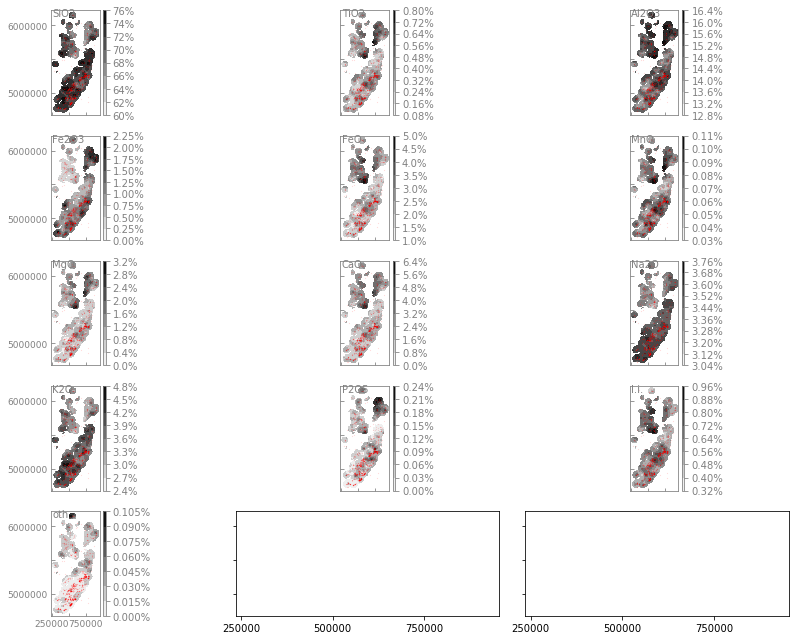

In [71]:
# Specify how many rows and columns you want to use in the following figure
# This will ofcourse depend an the number of variables you would like to plot
# You can also set the figure size
n_cols = 3
n_rows = 5

# Figure with single mineral maps as subplots
plots.plot_contour_map_all(interpolated_modal,
                           grid,
                           coordinates_utm,
                           group_name,
                           title=f"radius={range_[0]}m masked {critical_distance}m",
                           show_plot=True,
                           label_pos = (0.03, 0.94),
                           skip_xaxis_label=2,
                           skip_yaxis_label=2,
                           skip_xaxis_start=1,
                           skip_yaxis_start=1,
                           marker_size=0.1,
                           marker_color='r',
                           marker_symbol='.',
                           figsize=(12, 9),
                           ncols=n_cols,
                           nrows=n_rows,
                           sharex=True,
                           sharey=True)

## QAPF maps
____

In [88]:
interpolated_mineralogy = pd.read_excel("../_CIPW/CIPW/AREA2/qapf.xlsx")

In [89]:
interpolated_reverse_clr = pd.read_excel("../_CIPW/CIPW/AREA2/interpolated_data.xlsx")

In [90]:
interpolated_mineralogy = interpolated_mineralogy.set_index(" SAMPLE")

In [91]:
interpolated_mineralogy["QAPF_numbers"] = interpolated_mineralogy["QAPF"].map(qapf.QAPF_upper_regions_numbers)

In [92]:
interpolated_mineralogy

,Q,P,K,QAPF,QAPF_numbers
SAMPLE,,,,,
6777,30.714441,35.287762,25.602160,monzo granite,5
6778,30.872406,35.108984,25.725803,monzo granite,5
6779,30.876396,35.097920,25.739176,monzo granite,5
6780,30.883366,35.084152,25.754179,monzo granite,5
6781,30.935518,35.040522,25.750338,monzo granite,5
...,...,...,...,...,...
261339,29.905159,36.901846,22.854250,monzo granite,5
261340,29.875734,36.926955,22.843477,monzo granite,5
261341,29.851463,36.946808,22.835602,monzo granite,5


In [93]:
interpolated_mineralogy_QAPF = pd.merge(interpolated_reverse_clr, interpolated_mineralogy, 
                                        left_index=True, right_index=True, how='outer')\
                                 .drop(interpolated_reverse_clr.columns, axis=1)

interpolated_mineralogy_QAPF = interpolated_mineralogy_QAPF.fillna(0)
interpolated_mineralogy_QAPF

,Q,P,K,QAPF,QAPF_numbers
0,0.0,0.0,0.0,0,0.0
1,0.0,0.0,0.0,0,0.0
2,0.0,0.0,0.0,0,0.0
3,0.0,0.0,0.0,0,0.0
4,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...
266107,0.0,0.0,0.0,0,0.0
266108,0.0,0.0,0.0,0,0.0
266109,0.0,0.0,0.0,0,0.0
266110,0.0,0.0,0.0,0,0.0


In [94]:
interpolated_mineralogy_QAPF_reshape = np.reshape(interpolated_mineralogy_QAPF["QAPF_numbers"].values, (grid[1].shape[0], grid[0].shape[0]))

In [95]:
values_to_plot = list(np.sort(interpolated_mineralogy_QAPF["QAPF_numbers"].unique()))[1:]
values_to_plot

[5.0, 6.0, 11.0]

In [96]:
# Need to have correct excel file with area's control points' CIPW-QAPF classification
mineralogy_QAPF = pd.read_excel("../_CIPW/CIPW/AREA1/QAPF_control_points.xlsx", index_col=0)

In [97]:
QAPF_to_plot = pd.merge(coordinates_utm, mineralogy_QAPF[["QAPF"]], left_index=True, right_index=True)

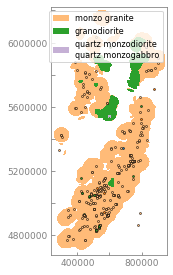

In [98]:
plots.plot_contour_map_interpolated_QAPF(interpolated_mineralogy_QAPF_reshape, grid, QAPF_to_plot, f"{group_name}", values_to_plot=values_to_plot,
                                         skip_xaxis_label=2, skip_yaxis_label=2, skip_xaxis_start=1, skip_yaxis_start=1, show_qapf_control_points=True)

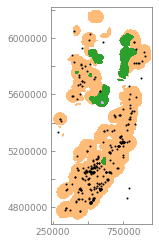

In [100]:
plots.plot_contour_map_interpolated_QAPF(interpolated_mineralogy_QAPF_reshape, grid, QAPF_to_plot, f"{group_name}", values_to_plot=values_to_plot,
                                         skip_xaxis_label=2, skip_yaxis_label=2, skip_xaxis_start=1, skip_yaxis_start=1, show_qapf_control_points=False, no_legend=True)

## Biplots
____

Not relevant for now

## Simulations
____

Not relevant for now

## Error budget
____

In [72]:
# A = Variance of kriging surface
# B = mean squared prediction error (MSPE)
# C = Sum of nugget
# D = Total variance based on simulation (not yet available)
# E = Variance of original data set

error_budget = {}

for radius in search_radii:
    for ncomp in range(1, len(components_to_use) + 1):
        A = var_OK[:ncomp].sum()
        B = np.mean(np.sum(residuals_clr[f"{ncomp}_{radius}"] ** 2, axis=1), axis=0) # MSPE
        C = np.array(nugget_)[:ncomp].sum()
        D = np.nan
        E = mineralogy_clr.var(axis=0).sum()
        

        error_budget[f"{ncomp}_{radius}"] = [A, B, C, D, E]

In [73]:
error_budget_df = \
    ttest.convert_summary_test_results_to_df(error_budget, 
                                             variable_names=["VAR(OK)",
                                                             "MSPE", 
                                                             "S_nugget", # Sum of nuggets
                                                             "VAR(TOTAL)",
                                                             "VAR(DATA)"], 
                                             order=["search_radius", 
                                                    "#PCs"])
error_budget_df

,search_radius,#PCs,VAR(OK),MSPE,S_nugget,VAR(TOTAL),VAR(DATA)
0,120000,1,0.394760,6.028501,1.0685,NaN,6.023367
1,120000,2,0.625733,5.809960,1.7035,NaN,6.023367
2,120000,3,0.866868,5.626263,2.2965,NaN,6.023367
3,120000,4,1.047629,5.537036,2.7370,NaN,6.023367


In [74]:
error_budget_df.to_excel(f"../_RESULTS/Error_budget/error_budget_{group_name}.xlsx")

-----

## variance for each time class

In [75]:
metadata

,type_granite,time,massif,sampler,others,sampler+year
1,Granite leucogranitic,K,NaN,NaN,NaN,"V.N.Musin,1970"
7,Bt granite,K,NaN,N.A.Krivitskaya,NaN,"A.A.Golovneva,1950"
8,Granite fine-grained,K,NaN,NaN,NaN,"V.A.Yarmolyuk,1949"
13,Granite-porphyry,K,NaN,NaN,NaN,"I.A.Gaev,1960"
16,Granite,K,Nipnin massif,NaN,NaN,"L.V.Eyrish,1963"
...,...,...,...,...,...,...
4646,Quartz diorite,Pg,Terney massif,NaN,NaN,"V.V.Vetrennikov,1965"
4649,Quartz diorite,K,NaN,NaN,NaN,"A.A.Golovneva,1960"
4650,Bt-Px diorite,Pg,NaN,NaN,NaN,"V.V.Shadynsky,1966"
4654,Diorite,K,NaN,NaN,Det.:H2o+-0.60,"V.K.Matushkin,1972"


In [76]:
metadata['time'].value_counts()

K     715
Pg    315
J       7
Tr      1
Name: time, dtype: int64

In [77]:
mineralogy_clr1 = mineralogy_clr.loc[metadata['time'] == 'K']
mineralogy_clr2 = mineralogy_clr.loc[metadata['time'] == 'Pg']
mineralogy_clr3 = mineralogy_clr.loc[metadata['time'] == 'J']
mineralogy_clr4 = mineralogy_clr.loc[metadata['time'] == 'Tr']

In [78]:
print('variance for subset K is' ,  mineralogy_clr1.var(axis=0).sum())
print('variance for subset Pg is' ,  mineralogy_clr2.var(axis=0).sum())
print('variance for subset J is' ,  mineralogy_clr3.var(axis=0).sum())
print('variance for subset Tr is' ,  mineralogy_clr4.var(axis=0).sum())

variance for subset K is 5.865582909623047
variance for subset Pg is 6.321075565604089
variance for subset J is 4.24922498200643
variance for subset Tr is 0.0


-----

In [79]:
interpolated_reverse_clr.to_excel("../_CIPW/CIPW/AREA2/interpolated_data.xlsx")

In [80]:
interpolated_reverse_clr

,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
266107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
